<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn</h1>
</div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [2]:
from collections import namedtuple

In [3]:
from pprint import pprint

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

In [5]:
# Set numerical precision
# DTYPE = np.float64

In [102]:
# Imports for Cervino.
from cervino import *

<div class="alert alert-info">
    <h2>Cervino setup</h2>
</div>

General Cervino class which allows one to do most of the work. This class has methods to create the TOML file, the solver input file, to run the simulation, ...

In [7]:
workflow_type = 'forward'

In [8]:
workflow_dict = create_workflow_dict(workflow_type)

In [9]:
workflow_dict['compute_forward_simulation'] = SolverSite('matterhorn', 'local')

In [10]:
cervino_dict = {
    'workflow_type': workflow_type,
    'workflow_dict': workflow_dict,
    'name': 'marmousi_v15',
    'site': 'aug04',
    'desc': 'Simple Matterhorn forward simulation on the Marmousi model',
}

In [11]:
pprint(cervino_dict)

{'desc': 'Simple Matterhorn forward simulation on the Marmousi model',
 'name': 'marmousi_v15',
 'site': 'aug04',
 'workflow_dict': OrderedDict([('compute_forward_simulation',
                                SolverSite(solver='matterhorn', site='local'))]),
 'workflow_type': 'forward'}


In [12]:
marmousi = Cervino(**cervino_dict)

In [13]:
marmousi

Construct the dictionaries for the tasks that will compose the forward simulation pipe. This is done in another Notebook. Here, we load the tasks into the pipeline of the Cervino simulation:

In [14]:
marmousi.workflow.pipeline['compute_forward_simulation'].attach_tasks_from_pickle('tasks.pkl')

In [15]:
summary = marmousi.summary()
for line in summary:
    print(line)

The Cervino simulation will perform a 'forward' workflow.
There are 1 pipes in the workflow:
	The 0th pipe is 'compute_forward_simulation'
		The 0th task is 0000
		The 1th task is 0001
		The 2th task is 0002
The simulation has NOT been validated.


In [16]:
# pprint(marmousi.workflow.pipeline['compute_forward_simulation'].get_tasks_dict())['0001'])

<div class="alert alert-info">
    <h2>Validate simulation</h2>
</div>

Before running the simulation, we want to validate its input to make sure it is correct:

In [17]:
# marmousi.validate()

<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

This launches the simulation on the local workstation/laptop.

We first need to define a small dictionary with a few required parameters:

In [18]:
run_dict = {
    'progress': True,
    'verbose': True,
    'n_ranks': 8,
    'max_ranks': 16
}

In [19]:
# for a in marmousi.workflow.pipeline['compute_forward_simulation'].get_tasks_dict().values():
#     pprint(a)

In [115]:
result, output_files_hdf5 = marmousi.run(run_dict)

The number of concurrent jobs is 2
Executing pipe 'compute_forward_simulation' with solver 'matterhorn' on 'local'


In [117]:
output_files_hdf5

{'0000': '0000.h5', '0001': '0001.h5', '0002': '0002.h5'}

In [ ]:
# for i in result['compute_forward_simulation']:
#     print(i[0].decode("utf-8") )

In [ ]:
# marmousi.get_output_files(verbose=False)

In [119]:
# task = marmousi.workflow.pipeline['compute_forward_simulation']._tasks_dict['0002']
# pprint(task)

In [120]:
ofd = Tasks._get_output_files_from_task(marmousi.workflow.pipeline['compute_forward_simulation']._tasks_dict['0002'])
pprint(ofd)

{'gather_0000': ('gather', '0002_0000_vz_gather'),
 'slice_dft_0000': ('slice_dft', '0002_0000_sxx_dft_slice'),
 'slice_time_0000': ('slice_time', '0002_0000_vx_slice'),
 'slice_time_0001': ('slice_time', '0002_0001_vz_slice')}


In [49]:
import xarray as xr

In [124]:
ds = xr.load_dataset('0001.h5')

In [125]:
ds.data_vars

Data variables:
    gather_0000      (time_gather, traces) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    slice_time_0000  (time_slice, x, z) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    slice_time_0001  (time_slice, x, z) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    slice_dft_0000   (freq_dft, z, x) float32 -2.6515855e-23 ... 0.0

In [126]:
ds.dims

Frozen(SortedKeysDict({'time': 5000, 'time_gather': 500, 'traces': 2301, 'time_slice': 50, 'x': 2301, 'z': 751, 'freq_dft': 16}))

In [127]:
# da = ds['gather_0000']
da = ds['slice_time_0000']

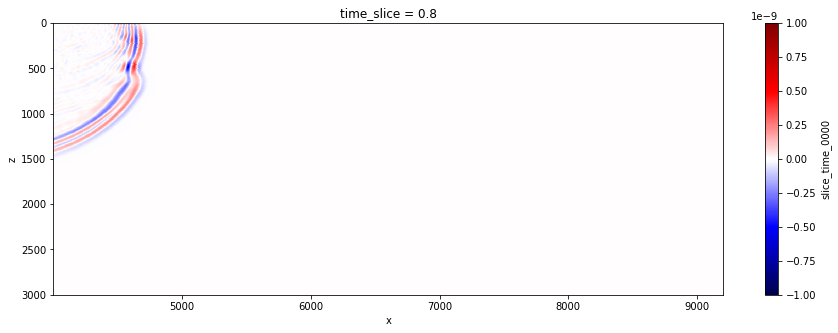

In [128]:
clip = 1e-9
vmin, vmax = -clip, clip
da[da.time_slice==0.8, da.x>4000, :].T.plot(aspect="auto", figsize=(15, 5), yincrease=False, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)

In [129]:
da = ds['slice_dft_0000']

In [130]:
da.coords

Coordinates:
  * x         (x) float64 0.0 4.0 8.0 12.0 ... 9.192e+03 9.196e+03 9.2e+03
  * z         (z) float64 0.0 4.0 8.0 12.0 ... 2.992e+03 2.996e+03 3e+03
  * freq_dft  (freq_dft) int64 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80

In [131]:
da.dims

('freq_dft', 'z', 'x')

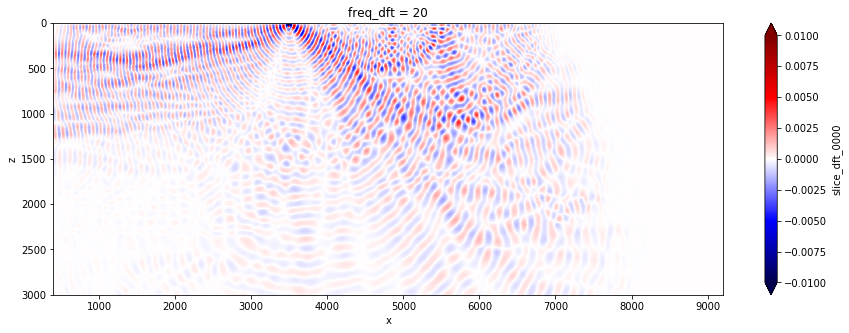

In [132]:
clip = 1e-2
vmin, vmax = -clip, clip
da[da.freq_dft==20, :, da.x>400].plot(aspect="auto", figsize=(15, 5), yincrease=False, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [ ]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

In [ ]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 15)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [ ]:
sufile.close()

<div class="alert alert-info">
    <h2>Convert output to HDF5</h2>
</div>

In [ ]:
import h5py

In [ ]:
from pathlib import Path

In [ ]:
fn = f'{marmousi.name}.h5'
print(fn)

In [ ]:
marmousi.convert_output_to_hdf5()

In [ ]:
outputs = marmousi.get_output_files()
pprint(outputs)

In [ ]:
for output_k, output_v in outputs.items():
    print(output_v[0])
    print(output_v[1])

In [ ]:
with h5py.File(fn, 'r') as f:
    print(type(f.attrs['groups']))
    print(f.attrs['groups'].dtype)
    print(f.attrs['groups'])
    print(type(f['slice_dft'].attrs['dft_frequencies']))
    b = f['slice_dft'].attrs['datasets']
    print(type(b))
    print(b.dtype)
    print(b)
    a = np.array(['ciao', 'ciaone'])
    print(a)
    print(a.dtype)
#     f['slice_dft'].attrs['datasets'] = a

In [ ]:
# print(fn)
with h5py.File(fn, 'r') as f:
    for item in f.keys():
        print(list(f[item].attrs['datasets']))
#         print(type(item))

In [ ]:
with h5py.File(fn, 'r') as f:
#     for item in f.attrs.keys():
#         print(item)
    print(f.attrs['groups'])

In [ ]:
with h5py.File(fn, 'r') as f:
    pprint(f['slice_time'].attrs['datasets'])

In [ ]:
print(fn)
with h5py.File(fn, 'r') as f:
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].imshow(f['slice_dft']['sxx_dft_slice'][12].real, cmap=plt.cm.seismic)
    ax[1].imshow(f['slice_dft']['sxx_dft_slice'][12].imag, cmap=plt.cm.seismic)

In [ ]:
print(fn)
with h5py.File(fn, 'r') as f:
    plt.imshow(f['slice_time']['vx_slice'][27].T, cmap=plt.cm.seismic)

In [ ]:
with h5py.File('marmousi_original_model/marmousi_original.h5', 'r') as f:
    print(f['VP'].shape)